# Art Style Classification and Period Detection

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)


Using: cuda


In [2]:
image_size = 224
batch_size = 64
epochs = 15
data_dir = "C:/Projects/WikiArt"

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)

val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

training, val_gen = random_split(dataset, [train_size, val_size])

training = DataLoader (
    training,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_gen = DataLoader(
    val_gen,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [9]:
# Load ResNet50

weights = models.ResNet50_Weights.IMAGENET1K_V2
base_model = models.resnet50(weights=weights)

for param in base_model.parameters():
    param.requires_grad = False

base_model.fc = nn.Sequential(
    nn.Linear(base_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

model = base_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
# Training loop

for epoch in range(epochs):
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in training:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total

    # validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_gen:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}")

torch.save(model.state_dict(), "resnet50_art_classifier.pth")
print("Model saved.")


Epoch 1/15 - Train Acc: 0.4071  Val Acc: 0.4800
Epoch 2/15 - Train Acc: 0.4819  Val Acc: 0.5196
Epoch 3/15 - Train Acc: 0.5092  Val Acc: 0.5268
Epoch 4/15 - Train Acc: 0.5266  Val Acc: 0.5329
Epoch 5/15 - Train Acc: 0.5414  Val Acc: 0.5303
Epoch 6/15 - Train Acc: 0.5548  Val Acc: 0.5374
Epoch 7/15 - Train Acc: 0.5674  Val Acc: 0.5497
Epoch 8/15 - Train Acc: 0.5756  Val Acc: 0.5427
Epoch 9/15 - Train Acc: 0.5883  Val Acc: 0.5506
Epoch 10/15 - Train Acc: 0.5936  Val Acc: 0.5470
Epoch 11/15 - Train Acc: 0.6002  Val Acc: 0.5457
Epoch 12/15 - Train Acc: 0.6083  Val Acc: 0.5512
Epoch 13/15 - Train Acc: 0.6148  Val Acc: 0.5454
Epoch 14/15 - Train Acc: 0.6171  Val Acc: 0.5516
Epoch 15/15 - Train Acc: 0.6230  Val Acc: 0.5526
Model saved.


Accuracy: 0.5526
Macro Precision: 0.6118
Macro Recall: 0.4960
Macro F1-Score: 0.5314
Top-5 Accuracy: 0.9214


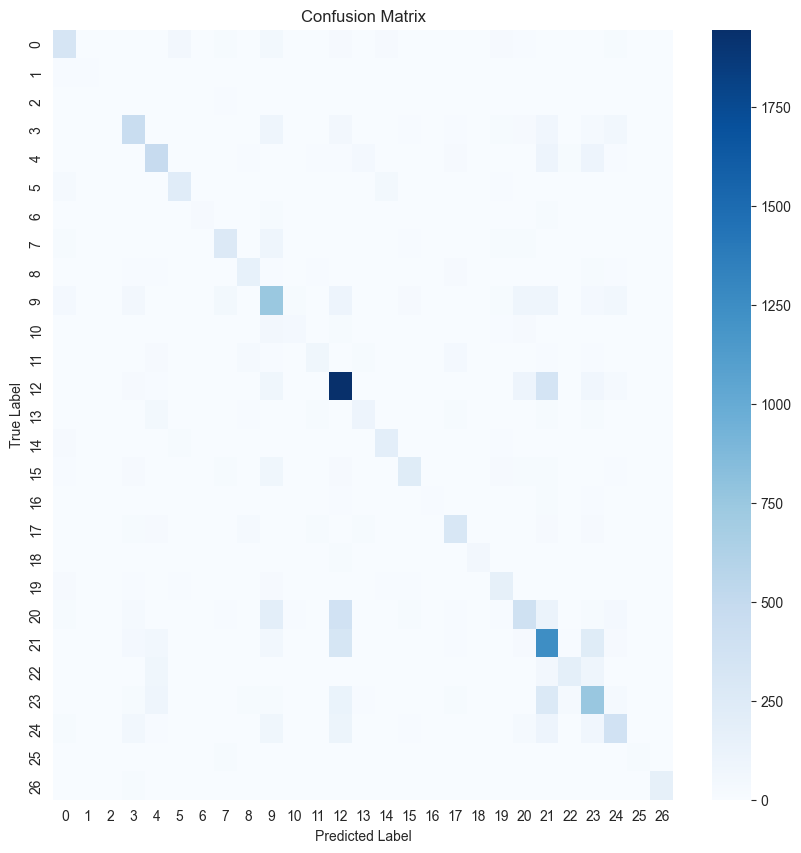

In [14]:
# Evaluation metrics

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_gen:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

top_5_acc = sum(all_labels[i] in np.argsort(all_probs[i])[-5:] for i in range(len(all_labels)))
top_5_accuracy = top_5_acc / len(all_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

## Results Summary

The model achieved 55.26% accuracy in classifying 27 different art styles, significantly better than random guessing (3.7%). The Top-5 accuracy of 92.14% shows the model's predictions are highly relevant even when not exact. The confusion matrix reveals some art styles are more distinct than others, with certain movements showing visual similarities that challenge classification.